### exploratory data analysis

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from sentence_transformers import SentenceTransformer, util
from collections import Counter
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import sklearn as skl
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
# spark.stop()  # stop any already running 

2024-05-25 19:52:59.034931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 19:52:59.034975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 19:52:59.035706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 19:52:59.039480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 19:52:59.645186: W tensorflow/compiler/tf2

In [2]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Read Cleaned Data") \
    .getOrCreate()


# Read the Parquet file into a DataFrame
s1clean = spark.read.parquet("online_retail_IIs1_clean.parquet/")
s2clean = spark.read.parquet("online_retail_IIs2_clean.parquet/")


24/05/25 19:53:01 WARN Utils: Your hostname, DESKTOP-25IG4QD resolves to a loopback address: 127.0.1.1; using 172.18.229.145 instead (on interface eth0)
24/05/25 19:53:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/25 19:53:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### collect product description text

In [5]:
# Get unique product descriptions
unique_descriptions_s1 = s1clean.select("Description").distinct()
unique_descriptions_s2 = s2clean.select("Description").distinct()

# Combine unique descriptions from both sheets
unique_descriptions = unique_descriptions_s1.union(unique_descriptions_s2).distinct()

# Collect the unique descriptions to a list
unique_descriptions_list = [row['Description'] for row in unique_descriptions.collect()]
print(len(unique_descriptions_list))
# for sent in tqdm(unique_descriptions_list):
    # sent.replace('  ',' ')
    # sent.strip(',*')
print(unique_descriptions_list)


5092
['blue stripe basket', 'spotty home sweet home doormat', 'white retrodisc lampshade', 'french enamel pot w lid', 'black flying ducks', 'new england ceramic cake server', 'purple bertie glass bead bag charm', 'crystal stud earrings assorted col', 'white rosebud pearl earrings', 'easter bunny garland flowers', 'door mat union jack guns and roses', 'black bird garden design mug', 'candy spot egg warmer hare', 'ass floral print spirit level', 'magic slate bunnies at home', 'flying saucer table light in white', 'wine bottle dressing dark blue', 'biscuit tin redivory vintage', 'fridge magnets les enfants assorted', 'easter tin chicks pink daisy', 'classic diamante earrings jet', 'blue round compact mirror', 'daisy ring', 'pinkwhite glass demi choker', 'bendy colour pencils', 'acrylic jewel icicle pink', 'pink heart candy button calculator', 'space boy birthday card', 'posy candy bag', 'silver candlepot jardin', 'vintage post office cabinet', 'pink gingham rose cushion cover', 'glass cha

In [6]:
all_descriptions = s1clean.select("Description").union(s2clean.select("Description")).toPandas()['Description']
# print(all_descriptions)
description_cnts = Counter(all_descriptions)
for key, value in sorted(description_cnts.items(), key=lambda x: x[0]): 
    print("{} : {}".format(key, value))

import pandas as pd
pd.DataFrame(description_cnts,index=range(5211)).to_csv("/mnt/g/WSL/description_counts.csv")

a pretty thank you card : 27
a wall tidy blue office : 9
a wall tidy red flowers : 6
abc treasure book box : 187
abstract circle journal : 117
abstract circles notebook : 54
abstract circles pocket book : 78
abstract circles sketchbook : 150
acrylic bead chain blue : 1
acrylic bead chain pink : 1
acrylic bead garlandpink : 2
acrylic geometric lamp : 20
acrylic hanging jewelblue : 32
acrylic hanging jewelpink : 7
acrylic jewel angelblue : 2
acrylic jewel angelpink : 7
acrylic jewel icicle blue : 8
acrylic jewel icicle pink : 20
acrylic jewel snowflake pink : 7
acrylic jewel snowflakeblue : 4
acrylic jewel snowflakepink : 9
adjustment by john on : 32
adjustment by peter on jun : 3
adult apron apple delight : 40
advent calendar gingham sack : 395
afghan slipper sock pair : 76
aged glass silver tlight holder : 562
airline bag vintage jet brown : 200
airline bag vintage jet red : 349
airline bag vintage jet white : 199
airline bag vintage tokyo : 520
airline bag vintage world champion : 233

### transform into semantic vector embeddings using TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(np.array(unique_descriptions_list))

embeddings = tfidf_matrix.toarray()
print(embeddings.shape)
cosine_scores = skl.metrics.pairwise.cosine_similarity(embeddings)
print(cosine_scores, cosine_scores.shape)

(5092, 2393)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] (5092, 5092)


### converting descriptions into embeddings using sentence-transformers

In [9]:
# # Load the pre-trained model and generate embeddings
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(unique_descriptions_list, show_progress_bar=True)
# from transformers import BertTokenizer, TFBertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# model = TFBertModel.from_pretrained("bert-base-cased")
# inputs = tokenizer(unique_descriptions_list, return_tensors='tf', padding=True)
# model?
# outputs = model(inputs)
# embeddings = outputs.last_hidden_state
# sentence_embeddings = tf.reduce_mean(embeddings, axis=1)
cosine_scores = util.cos_sim(embeddings, embeddings).numpy()


Batches:   0%|          | 0/160 [00:00<?, ?it/s]

### save cosine similarity values and embeddings

In [10]:
# print(cosine_scores.numpy())
print(embeddings)
with open("embeddings.npy", 'wb') as f:
    np.save(f, embeddings)
    print(embeddings.shape)
    
with open("embeddings_cosine_distance_matrix.npy", 'wb') as f:
    np.save(f, cosine_scores)
    print(cosine_scores)

[[ 0.02455588 -0.0840532  -0.01179607 ... -0.01298289  0.0259298
  -0.0204153 ]
 [ 0.00723474  0.01887008 -0.00742267 ... -0.00205132  0.00849399
   0.00802113]
 [ 0.03286747  0.01754413  0.0085357  ...  0.02023576  0.00095216
  -0.04354269]
 ...
 [ 0.01666582 -0.01269322  0.02699038 ...  0.01043825  0.04434117
  -0.01063538]
 [-0.04922303 -0.00854574  0.00187171 ...  0.01155721 -0.02828915
   0.01488158]
 [ 0.01419219 -0.00979879 -0.02422146 ...  0.01852471  0.01868946
  -0.01183387]]
(5092, 768)
[[ 1.          0.11527353  0.18628405 ...  0.1111045   0.07657903
   0.15285018]
 [ 0.11527353  1.          0.10033733 ... -0.03596229  0.07135282
   0.16188611]
 [ 0.18628405  0.10033733  0.9999999  ... -0.04904617  0.11136685
   0.08452158]
 ...
 [ 0.1111045  -0.03596229 -0.04904617 ...  1.         -0.01526603
   0.05657637]
 [ 0.07657903  0.07135282  0.11136685 ... -0.01526603  1.0000002
   0.07735577]
 [ 0.15285018  0.16188611  0.08452158 ...  0.05657637  0.07735577
   0.99999976]]


/tmp/ipykernel_832458/4109258436.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(8,3))


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f3ba4287700> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <function tqdm.__del__ at 0x7f3bc4c51dc0>
Traceback (most recent call last):
  File "/home/lreclusa/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

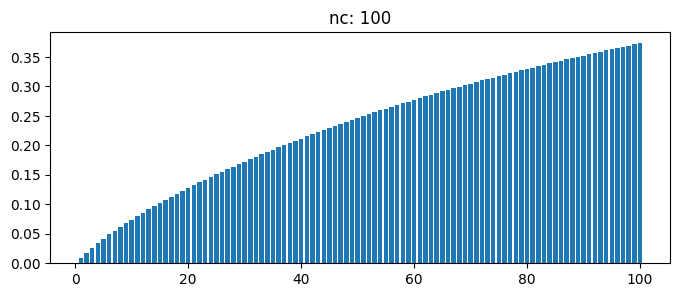

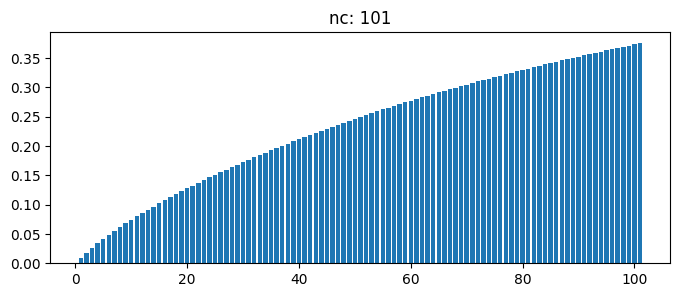

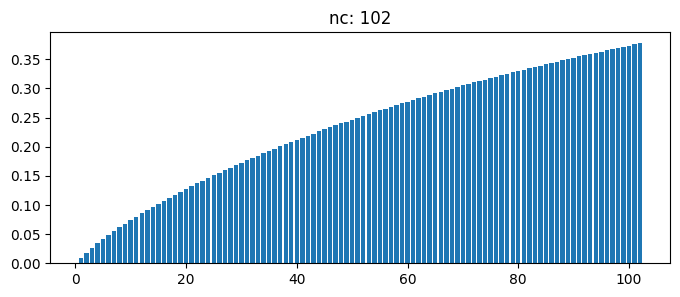

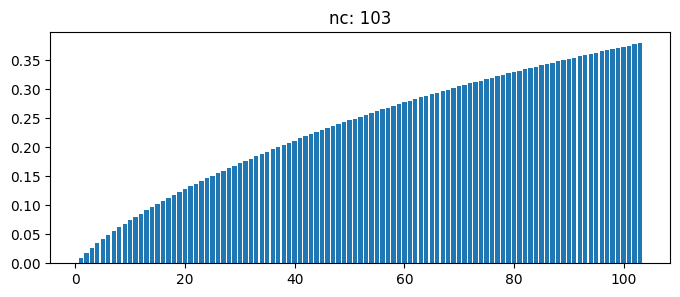

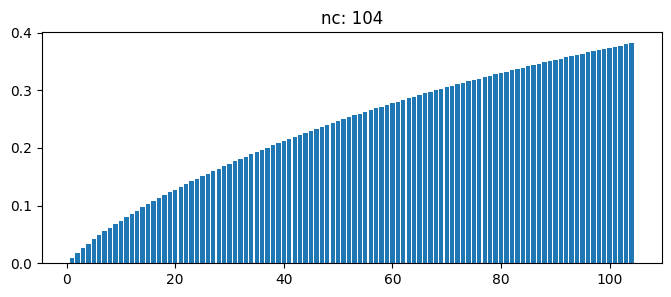

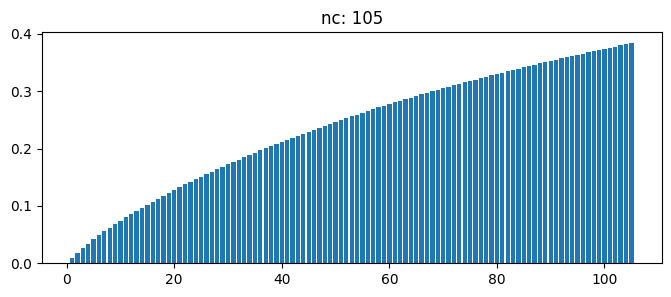

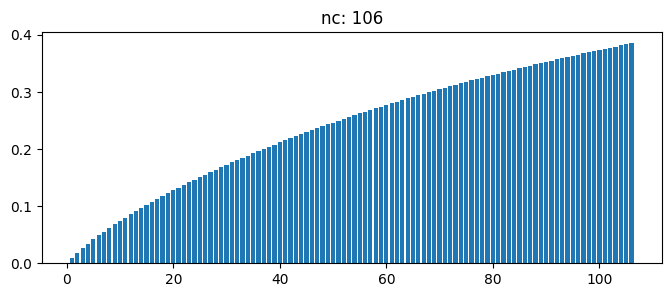

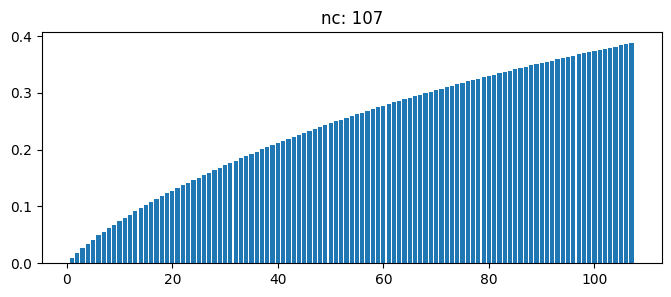

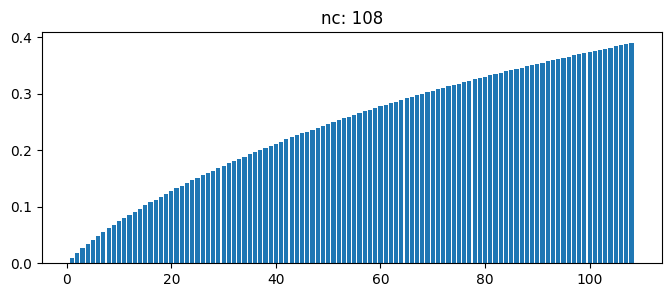

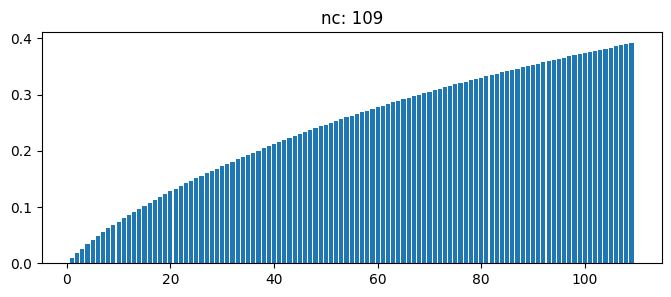

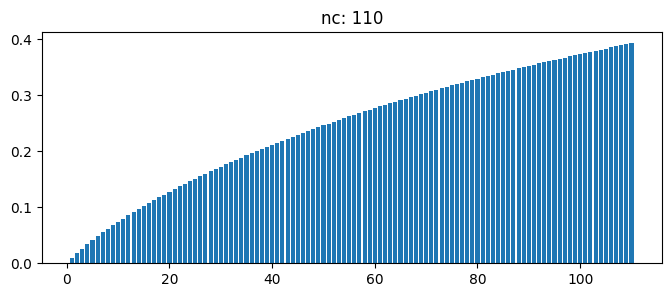

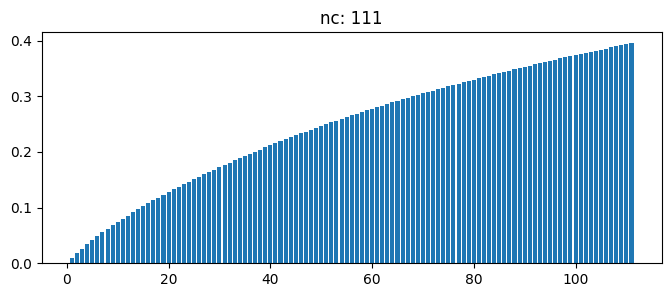

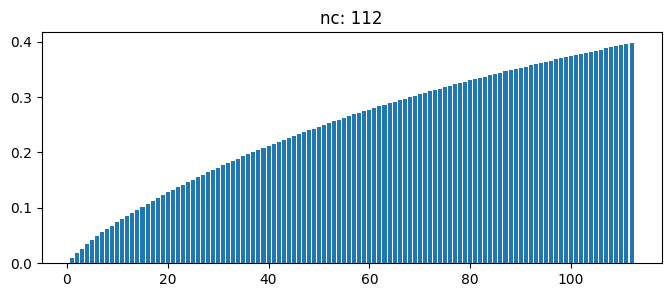

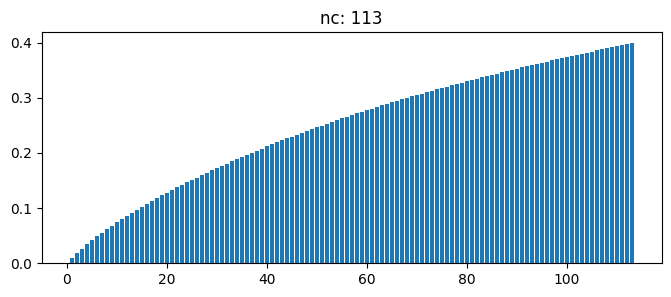

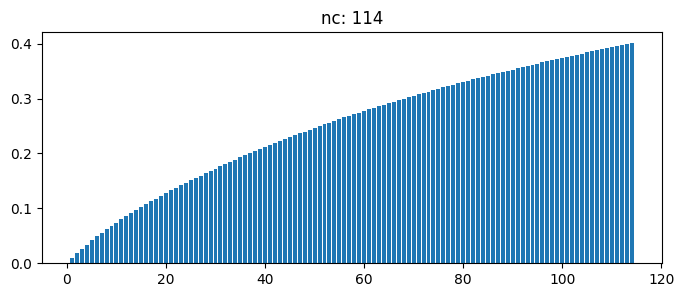

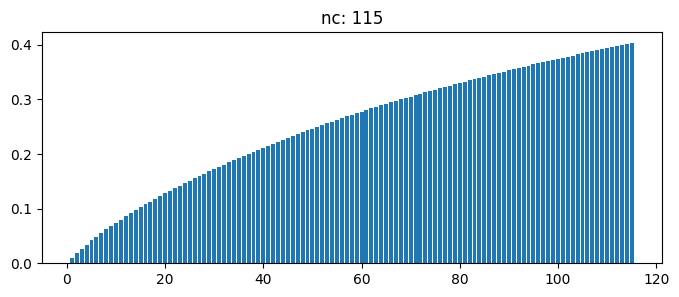

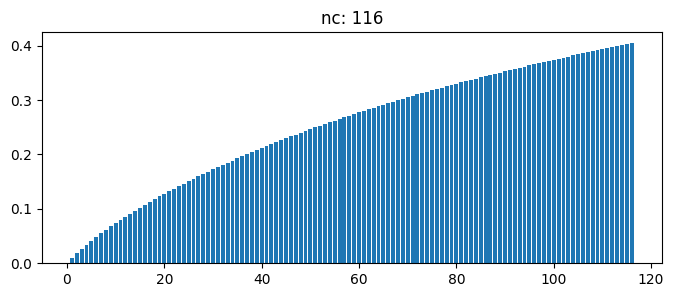

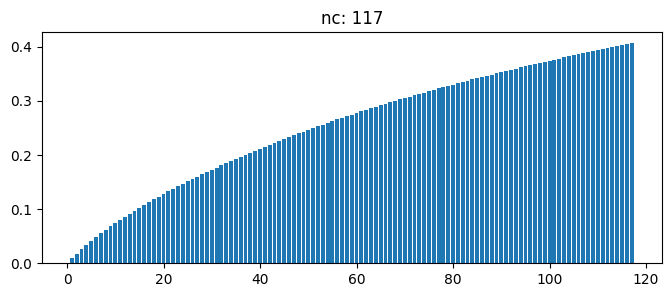

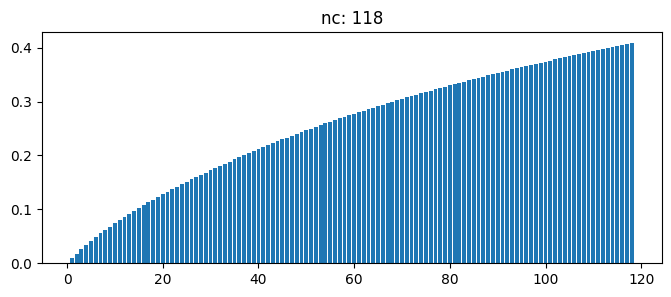

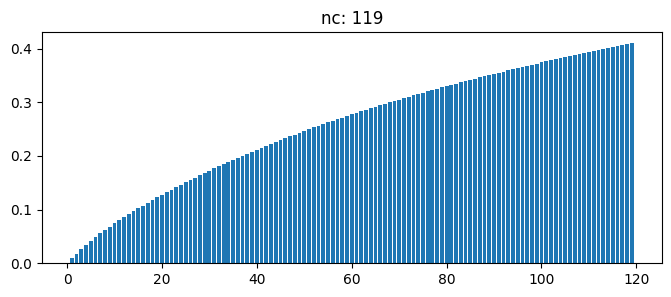

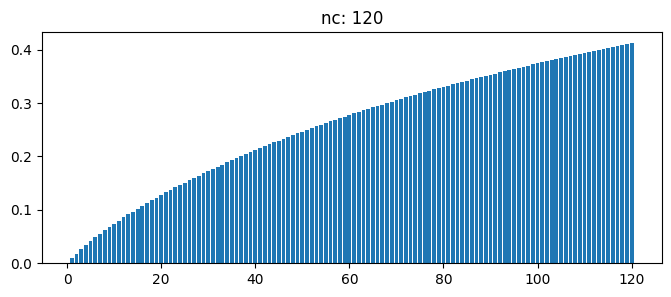

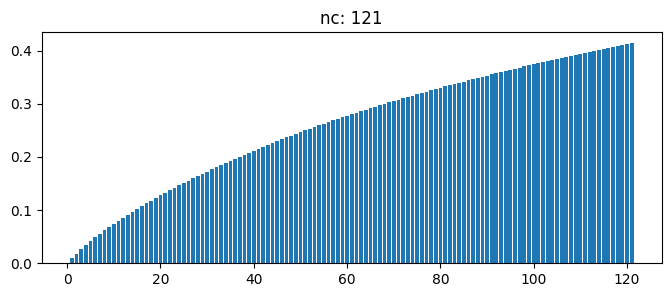

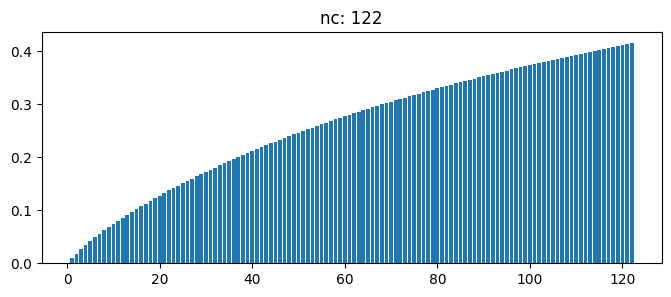

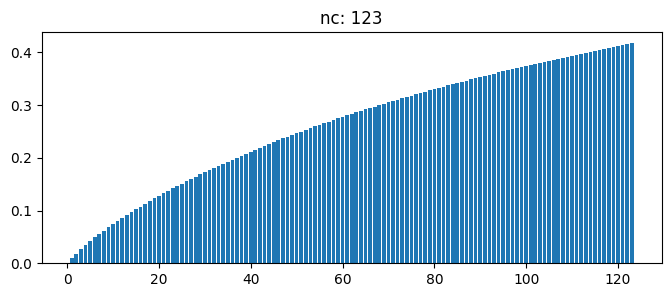

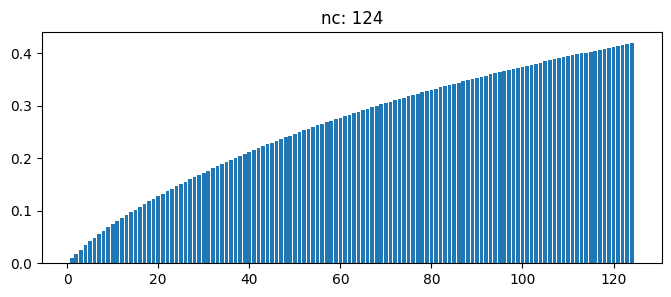

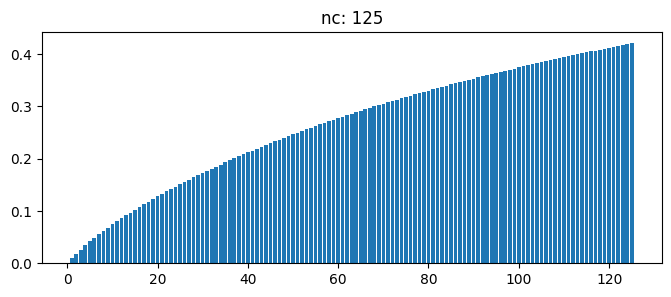

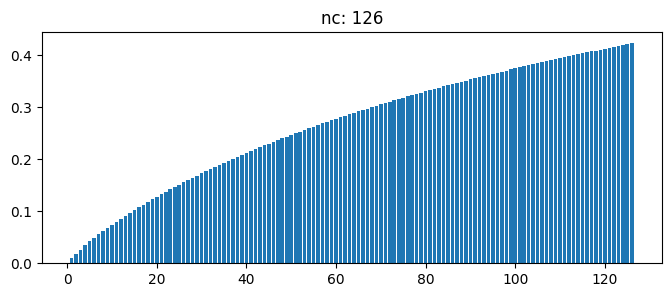

In [67]:
from sklearn.decomposition import PCA
def make_pca_model(nc):
    pca = PCA(nc)
    pca.fit(embeddings)
    return pca

for ii in range(100,300):
    ipca = make_pca_model(ii)
    explained_variance = np.cumsum(ipca.explained_variance_ratio_)
    fig,ax = plt.subplots(figsize=(8,3))
    ax.bar(range(1, len(explained_variance) + 1), explained_variance, align='center')
    ax.set_title(f'nc: {ii}')
    if max(explained_variance) > 0.95:
        break

### cluster product description embedding vectors with KMeans

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from hdbscan.validity import validity_index
from collections import Counter
import warnings

# warnings.filterwarnings('ignore')

X = embeddings
length = np.sqrt((X**2).sum(axis=1))[:,None]
X = X.astype('float64') / length
best_score = -np.inf
kept_res = None
for ii in tqdm(range(2,102)):
    mdl = KMeans(n_clusters=ii, tol=1e-6).fit(X)
    labels = mdl.labels_
    try:
        # scores = silhouette_score(X, labels)
        sample_scores = silhouette_samples(X, labels)
        scores = np.average(
            [np.median(sample_scores[labels==jj]) for jj in range(ii)],
            weights=[np.sum(labels==jj)/X.shape[0] for jj in range(ii)]
        )
        # all_group_sil_scores = []
        # for jj in range(ii):
            # frac = sum(labels==ii) / len(labels)
            # all_group_sil_scores.append(np.median(sample_scores[labels==jj]))
        # scores = np.median(all_group_sil_scores)
        if scores > best_score:
            kept_res = (ii, mdl, labels, scores)
            best_score = scores

    except:
        pass
    if (ii % 10) == 0 and kept_res:
        print(kept_res[0], best_score)
print(kept_res[0], kept_res[-1])


  0%|                                                                                                                                              | 0/100 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  9%|████████████                                                                                                                          | 9/100 [00:04<00:44,  2.04it/s]

10 0.03143258248696895


 19%|█████████████████████████▎                                                                                                           | 19/100 [00:09<00:39,  2.08it/s]

20 0.047817068079409636


 29%|██████████████████████████████████████▌                                                                                              | 29/100 [00:14<00:35,  2.00it/s]

27 0.0545815004219449


 39%|███████████████████████████████████████████████████▊                                                                                 | 39/100 [00:21<00:47,  1.29it/s]

39 0.062736461152315


 49%|█████████████████████████████████████████████████████████████████▏                                                                   | 49/100 [00:26<00:27,  1.85it/s]

50 0.06752002237528484


 59%|██████████████████████████████████████████████████████████████████████████████▍                                                      | 59/100 [00:32<00:25,  1.63it/s]

53 0.0691688756591955


 69%|███████████████████████████████████████████████████████████████████████████████████████████▊                                         | 69/100 [00:39<00:20,  1.55it/s]

64 0.0706255322444305


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 79/100 [00:45<00:13,  1.53it/s]

78 0.0717998526791005


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 89/100 [00:51<00:06,  1.67it/s]

90 0.07428289761815725


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:58<00:00,  1.42it/s]

99 0.07563498326459481


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]

99 0.07563498326459481


(99, KMeans(n_clusters=99, tol=1e-06), array([68, 58, 89, ..., 17, 69,  4], dtype=int32), 0.07563498326459481)


<BarContainer object of 99 artists>

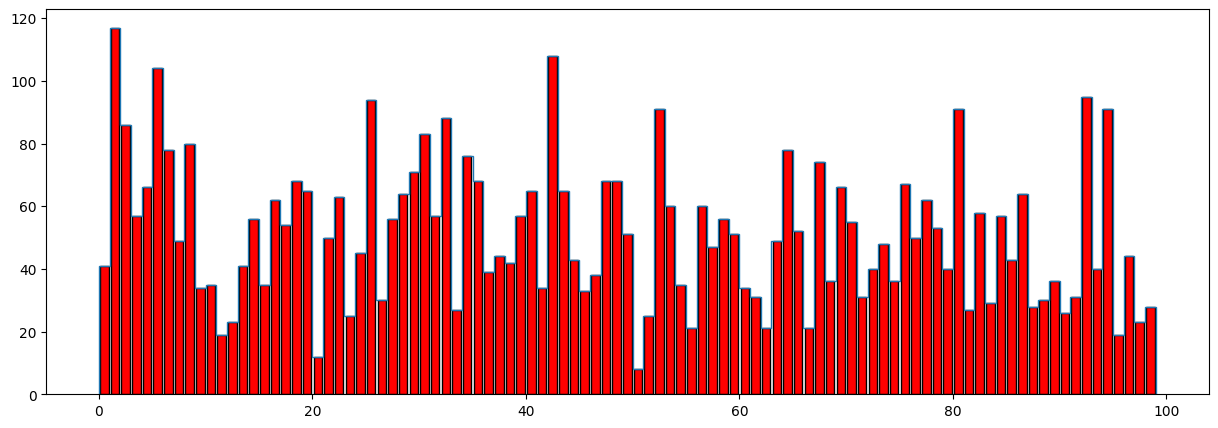

In [12]:
print(kept_res)
fig,axs = plt.subplots(figsize=(15,5),nrows=1)
axs.xaxis.get_majorticklocs()
histdata = axs.hist(kept_res[2], histtype='step', bins=np.arange(0,kept_res[0]+1,1))
# ax.clear()
lblcnts = Counter(kept_res[2])
ordered_cnts = [lblcnts[ii] for ii in range(kept_res[0])]
axs.bar(range(kept_res[0])+0.5*abs(np.diff(histdata[1][:2])), ordered_cnts, color='red', ec='black')

### map these labels back onto the original datasets

In [21]:
product_group_id = [str(i) for i in kept_res[2]]
data = list(zip(unique_descriptions_list, product_group_id))
distinct_descriptions_df = spark.createDataFrame(data, ["description", "product_group_id"])

def map_cluster_ids(original_df, distinct_descriptions_df):
    # Join the original dataset with the distinct descriptions DataFrame on the description column
    mapped_df = original_df.join(distinct_descriptions_df, original_df.Description == distinct_descriptions_df.description, "left") \
                           .select(original_df["*"], distinct_descriptions_df["product_group_id"])
    
    return mapped_df

# Apply the function to map cluster IDs
# s1clean = map_cluster_ids(s1clean, distinct_descriptions_df)

# Show the results
columns_to_select = ['Description','product_group_id']
df_selected = s1clean.select(columns_to_select)
# Show the DataFrame with the selected columns
df_selected.show()

AnalysisException: [AMBIGUOUS_REFERENCE] Reference `product_group_id` is ambiguous, could be: [`product_group_id`, `product_group_id`].